# Exploración de datos para series temporales

In [28]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram
from scipy import fftpack

Monterrey = pd.read_csv("Files/Datos_2022_2023_CENTRO_limpios.csv", parse_dates=[0], index_col = "date")

## Funciones 

In [47]:
def graficar_serie_tiempo(df, contaminante):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df.index, y=df, name=f'{contaminante}'))
        
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        )
    )

    fig.show()

def Periodograma(ts, detrend='linear', window='boxcar', scaling='density', ts_frequency=None, show_minor_ticks=True, axsize=(12, 3)): 
    """
    Take timeseris and plot the periodogram(s).
    If data has multiple columns, one plot is made
    for each column.
    The time period format (df.index.to_period()) is
    preferred for clarity, but any format will work.

    Parameters
    ----------
    ts : DataFrame or Series with data to visualize
    detrend : whether and how to detrend the data
    window : the shape of the time window
    scaling : return either power spectral density
              or power spectrum
    ts_frequency : override timeseries index frequency
                   (for display only, in the xlabel)
    show_minor_ticks : plot minor ticks
    axsize : the size of a single plot in the figure

    Returns
    -------
    list_periods_spectra: List of tuples (periods, spectrum) for each time series
    """

    list_periods_spectra = []
    if not isinstance(ts, pd.Series) and not isinstance(ts, pd.DataFrame):
        raise Exception(f'data must be pd.Series or pd.DataFrame')
    if isinstance(ts, pd.Series):
        ts = pd.DataFrame(ts)

    num_cols = len(ts.columns.to_list())
    fig, ax = plt.subplots(num_cols, 1, figsize=(axsize[0], num_cols * axsize[1]), layout='constrained')
    if num_cols == 1:
        ax = np.array([ax])
    for i in range(num_cols):
        c = ts.columns.to_list()[i]
        frequencies, spectrum = periodogram(
            ts[c],
            fs=1,
            detrend=detrend,
            window=window,
            scaling=scaling,
        )
        with np.errstate(divide='ignore'):
            periods = 1 / frequencies
            list_periods_spectra.append((periods, spectrum))
        ax[i].step(periods, spectrum, color="purple")
        ax[i].set_xscale("log")
        ax[i].xaxis.set_major_formatter('{x:.0f}')
        if show_minor_ticks:
            ax[i].xaxis.set_minor_formatter('{x:.0f}')
            ax[i].grid(visible=True, which='both', axis='both')
        else:
            ax[i].grid(visible=True, which='major', axis='both')
        xlabel = f'Periodo (Días)'
        if ts_frequency is not None:
            xlabel += f', freqstr: {ts_frequency}'
        else:
            if hasattr(ts.index, 'freqstr'):
                xlabel += f', freqstr: {ts.index.freqstr}'
        ax[i].set_xlabel(xlabel)
        if scaling == 'density':
            ax[i].set_ylabel("power spectral density")
        else:
            ax[i].set_ylabel("power spectrum")
        ax[i].set_title(c)
    fig.suptitle('Periodogram')
    fig.show()
    return list_periods_spectra

def Top_10_Periodogram(df, list_periods_spectra):
    # Crear el DataFrame para los top 10
    columns = df.columns
    top_data = []

    for i, (periods, spectrum) in enumerate(list_periods_spectra):
        # Ordenar espectros en orden descendente y tomar los top 10
        top_indices = np.argsort(spectrum)[-10:][::-1]
        top_periods = periods[top_indices]
        top_spectra = spectrum[top_indices]
        
        # Crear una lista con los resultados ordenados
        top_data.extend([(columns[i], p, s) for p, s in zip(top_periods, top_spectra)])

    # Convertir a DataFrame
    results_df = pd.DataFrame(top_data, columns=["series", "top_periods", "top_spectra"])

    # Mostrar el DataFrame ordenado
    results_df = results_df.sort_values(by=["series", "top_spectra"], ascending=[True, False])
    display(results_df)

## PM 10

In [30]:
Monterrey_PM10 = Monterrey[["PM10", "PRS", "RAINF", "RH", "SO2", "SR", "TOUT", "WSR", "WDR"]]

In [31]:
Monterrey_PM10

,PM10,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
date,,,,,,,,,
2022-01-01 00:00:00,134.0,705.5,0.0,46.0,5.3,2.775558e-17,21.37,3.4,267.0
2022-01-01 01:00:00,141.0,705.2,0.0,48.0,6.1,2.775558e-17,20.83,3.3,259.0
2022-01-01 02:00:00,117.0,705.1,0.0,46.0,5.8,2.775558e-17,20.52,5.9,233.0
2022-01-01 03:00:00,108.0,704.8,0.0,46.0,6.0,2.775558e-17,20.12,5.1,220.0
2022-01-01 04:00:00,106.0,704.8,0.0,46.0,5.6,2.775558e-17,19.85,4.7,244.0
...,...,...,...,...,...,...,...,...,...
2023-08-17 19:00:00,48.0,708.9,0.0,19.0,3.5,3.000000e-02,36.24,15.1,68.0
2023-08-17 20:00:00,44.0,709.3,0.0,21.0,2.6,2.000000e-03,35.08,13.2,80.0
2023-08-17 21:00:00,47.0,709.8,0.0,22.0,2.5,2.775558e-17,34.23,8.7,100.0


In [32]:
graficar_serie_tiempo(Monterrey_PM10["PM10"], "PM10")

C:\Users\José Antonio\AppData\Local\Temp\ipykernel_2472\548813410.py:87: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



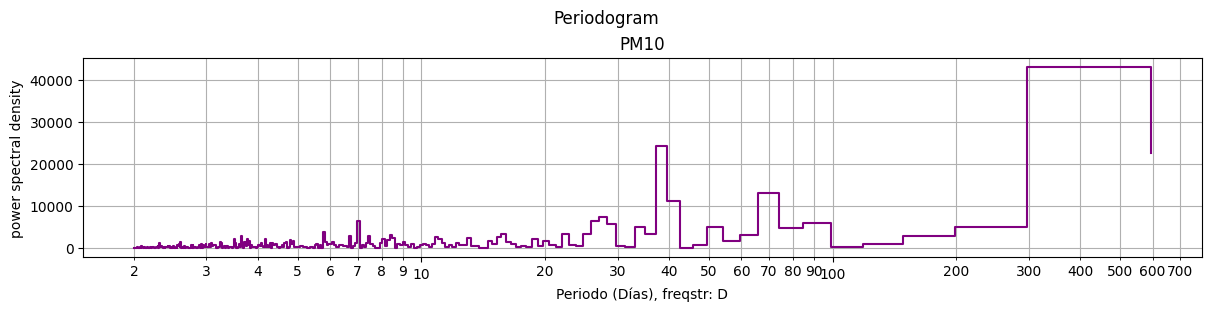

In [45]:
daily_pm10 = Monterrey_PM10['PM10'].resample('D').mean()
daily_pm10 = pd.DataFrame(daily_pm10)
list_periods_spectra = Periodograma(daily_pm10)

In [48]:
Top_10_Periodogram(daily_pm10, list_periods_spectra)

,series,top_periods,top_spectra
0,PM10,297.000000,43089.661431
1,PM10,37.125000,24372.635193
2,PM10,594.000000,22712.081778
3,PM10,66.000000,13149.515759
4,PM10,39.600000,11205.950944
5,PM10,27.000000,7517.806027
6,PM10,25.826087,6490.400153
7,PM10,6.988235,6411.128381
8,PM10,84.857143,6016.710748
9,PM10,28.285714,5679.708602


## SO2

## CO

In [ ]:
Monterrey_CO = Monterrey[["CO", "PRS", "RAINF", "RH", "SO2", "SR", "TOUT", "WSR", "WDR"]]

## NOX

In [ ]:
Monterrey_NOX = Monterrey[["NOX", "PRS", "RAINF", "RH", "SO2", "SR", "TOUT", "WSR", "WDR"]]

## COV

In [ ]:
Monterrey_COV = Monterrey[["COV", "PRS", "RAINF", "RH", "SO2", "SR", "TOUT", "WSR", "WDR"]]

KeyError: "['COV'] not in index"

## NH3